# plot time profile

In [12]:
import pathlib
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import scipy.signal as signal
import cv2 as cv
from PIL import Image
from time import time
import platform
from skimage.util.shape import view_as_windows
from scipy import ndimage
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi']= 300
mpl.rcParams.update({'figure.autolayout': True})

plt.rcParams.update({'figure.max_open_warning': 0})
np.set_printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', '{:,.4f}'.format)

_platform = platform.platform()
print('platform:', _platform, platform.node())
if 'linux' in _platform: # linux
    video_path = '/home/cclee/image_data/'
    out_path = '/home/cclee/tmp/rat/'
    train_path = '/home/cclee/tmp/rat/new_grooming/'
elif 'Darwin' in _platform: # MAC OS X
    rat_path = '/Users/cclee/rat_data/new_grooming/'
elif 'Windows' in _platform: # Windows
    if platform.node()=='Mozart':
        rat_path = 'e:/rat_data/new_grooming_0311'
        out_path = 'e:/rat_data/'
    else:
        rat_path = 'd:/rat_data/new_grooming_0311'
        out_path = 'd:/rat_data/'   
    
dpath = pathlib.Path(out_path)
groompath = pathlib.Path(rat_path)

rat_dir = '930217-base-1d'

jump_rows = 5
th_min_duration = 10
thMin = 0.009
thMax = 0.08
left_right = 'L'
mid_line = 180  
width = None
height = None
fps = 20
fps_out = 10   
frame_loc = 0   

read_cols = (0, 6, 10)

dot_a = np.array([2**i for i in range(11,-1, -1)])
print(dot_a)

dot_b = np.array([2**i for i in range(22,-1, -1)])
print(dot_b)


platform: Windows-10-10.0.19041-SP0 Zephyrus
[2048 1024  512  256  128   64   32   16    8    4    2    1]
[4194304 2097152 1048576  524288  262144  131072   65536   32768   16384
    8192    4096    2048    1024     512     256     128      64      32
      16       8       4       2       1]


In [13]:
def read_data(filename, cols):   
    df = pd.read_csv(filename, index_col=0, usecols=cols)
    print(df.dtypes)
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    df = df.reset_index()
    df = df.rename(columns={"index":'time'})
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df = df.reset_index().set_index('time')
    df = df.rename(columns={"index":'frame'})
    df = df.reset_index()
    return df

dfile = dpath.joinpath(rat_dir, '_diff_L_930217.csv')
df_diff = read_data(dfile, cols=read_cols)

display(df_diff)

data_p5 = df_diff.loc[:, 'nonzero_p5']
total_frames = len(data_p5)
# each sample represents 5 frames (5 sec)
moving_win = view_as_windows(data_p5.values, (10,), 5)
win_mean = np.mean(moving_win, axis=1)
label = (win_mean > thMin) & (win_mean < thMax)
label[:jump_rows] = False
label =1*label
print(label)
#         print('win_mean.shape %d' % win_mean.shape)
#         print('nonzero of label %d' % np.count_nonzero(label))        
label_median = signal.medfilt(label,3)
label_median1 = signal.medfilt(label_median,3)

moving_win = view_as_windows(label_median1, (12,), 1)
dot = np.dot(moving_win, dot_a)
dot2T = np.append(dot, [label_median1[-11:]])

final_label2T = label_median1.copy()
for i in range(dot2T.shape[0]):
    if dot2T[i]==96:
        final_label2T[i:i+12] = 0
        
df_label = pd.DataFrame({'label':label,'label_md':label_median, 'label_md1':label_median1, 
#                        'dot3T':dot3T, 'final_label_3T':final_label3T,
                   'dot2T':dot2T, 'final_label_2T':final_label2T})     
 
df_label = df_label.astype(dtype={'label_md':np.int32, 'label_md1':np.int32, 'dot2T':np.int32, 'final_label_2T':np.int32})

# display(df_label)    
# df_label.to_csv('_label.csv')    

label_lst = list(df_label['final_label_2T'])
# print(len(label_lst))
# print(label_lst[:100])
a = np.array( [[a] * 5 for a in label_lst])
label_lst1 = a.flatten() 
# print(len(label_lst1))
print(label_lst1[:200])

dfL = df_diff[:len(label_lst1)]
dfL['label'] = label_lst1
# dfL['time'] = pd.to_datetime(dfL['time'])
# dfL['time'] = dfL['time'].astype('datetime64[s]')

print(dfL.dtypes)
print(dfL[50:70])  
dfL.to_csv('_label.csv')    

nonzero_p1    float64
nonzero_p5    float64
dtype: object


,time,frame,nonzero_p1,nonzero_p5
0,1970-01-01 00:00:00,0,0.0000,0.0000
1,1970-01-01 00:00:01,1,0.0000,0.0000
2,1970-01-01 00:00:02,2,0.0000,0.0000
3,1970-01-01 00:00:03,3,0.0000,0.0000
4,1970-01-01 00:00:04,4,0.0000,0.0000
...,...,...,...,...
81027,1970-01-01 22:30:27,81027,0.0000,0.0000
81028,1970-01-01 22:30:28,81028,0.0000,0.0000
81029,1970-01-01 22:30:29,81029,0.0000,0.0000
81030,1970-01-01 22:30:30,81030,0.0000,0.0000


[0 0 0 ... 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
time          datetime64[ns]
frame                  int64
nonzero_p1           float64
nonzero_p5           float64
label                  int32
dtype: object
                  time  frame  nonzero_p1  nonzero_p5  label
50 1970-01-01 00:00:50     50      0.0764      0.1610      0
51 1970-01-01 00:00:51     51      0.1614      0.1650      0
52 1970-01-01 00:00:52     52      0.1121      0.1680      0
53 1970-01-01 00:00:53     53      0.0141      0.1829      0
54 1970-01-01 00:00:54     54      0.0161      0.1615      0
55 1970-01-01 00:00:55     55      0.0039      0.1

<ipython-input-13-f4e0490a5e89>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfL['label'] = label_lst1


In [14]:
hours = mdates.HourLocator() 
tm_fmt = mdates.DateFormatter('%H:%M')

def plot_daily(df, ax, datemin, datemax, title, fname):
    ax.set_ylim(0, 1.5)

    # format the ticks
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(tm_fmt)

    ax.format_xdata = tm_fmt
    ax.set_xlim(datemin, datemax)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Difference', fontsize=12)
#     ax.fill_between('time', 'pred', data=df,  lw=0.2)
    ax.fill_between('time', 'label', data=df, color='r',  lw=0.2, alpha=0.7 , label='likely grooming clips') # 
    ax.fill('time', 'nonzero_p5', data=df, label='frame difference, d(t)' )

#     for i in range(2):
#         night_ss = pd.Series([-1.5, 1.5],  
#                      index=[ss_day.iloc[i]['time'], ss_day.iloc[i]['time']] )
#         night_ss.plot(ax=ax,alpha=0.6, color='k', linestyle='--')
        
#     ax.set_title(title)   
    legend = ax.legend(fontsize=12)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)    
    
    plt.savefig(fname, dpi=300)

time          datetime64[ns]
frame                  int64
nonzero_p1           float64
nonzero_p5           float64
label                  int32
dtype: object


,time,frame,nonzero_p1,nonzero_p5,label
0,1970-01-01 00:00:00,0,0.0000,0.0000,0
1,1970-01-01 00:00:01,1,0.0000,0.0000,0
2,1970-01-01 00:00:02,2,0.0000,0.0000,0
3,1970-01-01 00:00:03,3,0.0000,0.0000,0
4,1970-01-01 00:00:04,4,0.0000,0.0000,0
...,...,...,...,...,...
81020,1970-01-01 22:30:20,81020,0.0000,0.0294,0
81021,1970-01-01 22:30:21,81021,0.0000,0.0288,0
81022,1970-01-01 22:30:22,81022,0.0000,0.0204,0
81023,1970-01-01 22:30:23,81023,0.0000,0.0049,0


datemax  1970-01-01T23 1970-01-01 22:30:24 30


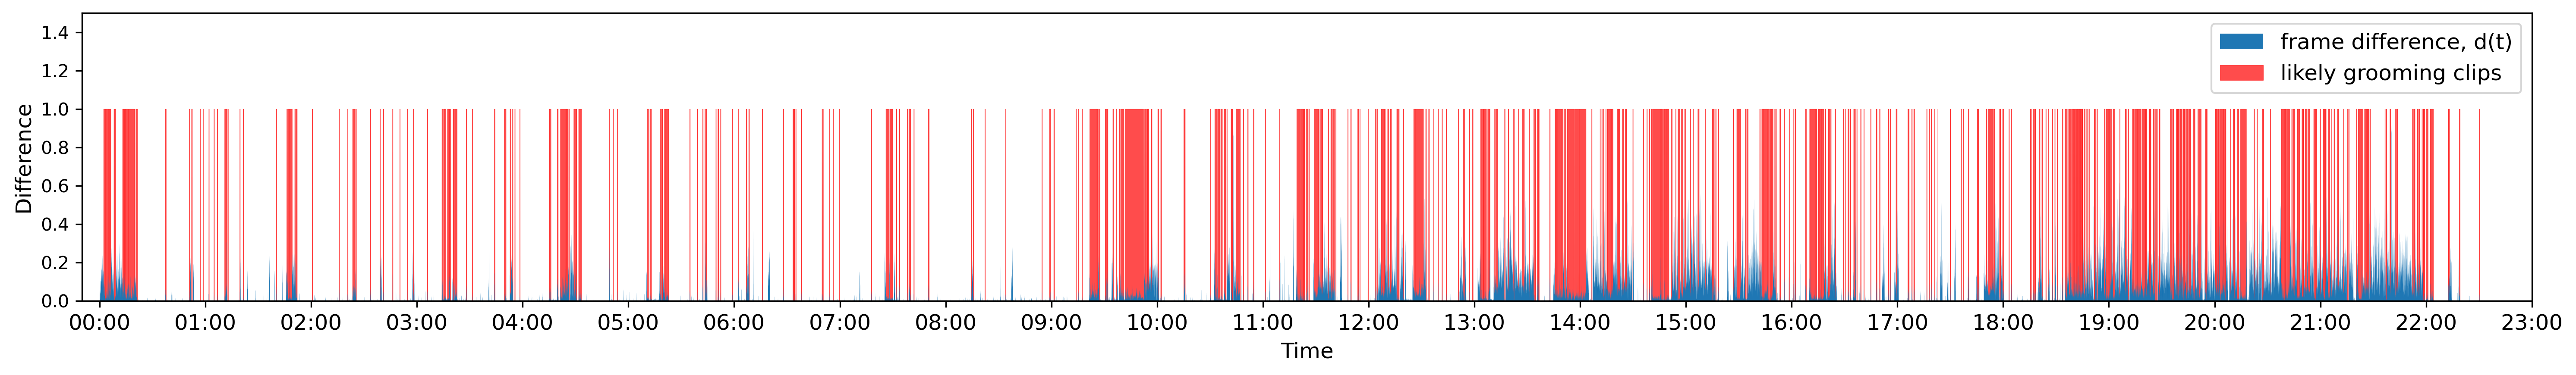

In [15]:
print(dfL.dtypes)
display(dfL)
titleL = '{}_L'.format('217')

        
datemin = np.datetime64(dfL.iloc[0]['time'], 'h') - np.timedelta64(10, 'm')
last_min = dfL.iloc[-1]['time'].minute
if last_min < 30:
    datemax = np.datetime64(dfL.iloc[-1]['time'], 'h') + np.timedelta64(30, 'm')
else:
    datemax = np.datetime64(dfL.iloc[-1]['time'], 'h') + np.timedelta64(1, 'h')
print('datemax ', datemax, dfL.iloc[-1]['time'], dfL.iloc[-1]['time'].minute)

f, ax = plt.subplots(1, 1, figsize=(20, 3), dpi=300, sharex=True)
plt.subplots_adjust(hspace=0.30)
# dfL['nonzero_p5'] = dfL['nonzero_p5']*2    
fname = 'fig3a_frame_difference_profile.png'
plot_daily(dfL, ax, datemin, datemax, titleL, fname)

# vertically concatenates images 
# read the images
# img1 = cv.imread(fname)
# crop_img = img1[:, 400:-350]
# cv.imwrite(fname, crop_img)

In [16]:
ratpath = dpath.joinpath(rat_dir)
print(ratpath)
start_frame = 43200 # 12:00
end_frame = 46800 # 13:00
files = sorted(ratpath.glob('930217_L*.csv'))
ftitles = [f.stem for f in files]

fstart = []
for f in ftitles:
    tok = f.split('_')
    fstart.append(int(tok[1][1:]))
 

clips = [f for f in fstart if start_frame<=f<end_frame]
ss_clips  = pd.Series(clips)
df_hour = pd.DataFrame({'frame': ss_clips})

# print(inhours)
# print(ss_hour)
df_hour['time'] = pd.to_datetime(df_hour['frame'], unit='s')
print(df_hour)

d:\rat_data\930217-base-1d
    frame                time
0   43410 1970-01-01 12:03:30
1   43470 1970-01-01 12:04:30
2   43625 1970-01-01 12:07:05
3   43730 1970-01-01 12:08:50
4   43840 1970-01-01 12:10:40
5   43865 1970-01-01 12:11:05
6   43930 1970-01-01 12:12:10
7   44150 1970-01-01 12:15:50
8   44210 1970-01-01 12:16:50
9   44370 1970-01-01 12:19:30
10  44725 1970-01-01 12:25:25
11  44785 1970-01-01 12:26:25
12  45135 1970-01-01 12:32:15
13  45235 1970-01-01 12:33:55
14  45405 1970-01-01 12:36:45
15  45555 1970-01-01 12:39:15
16  45690 1970-01-01 12:41:30
17  45835 1970-01-01 12:43:55
18  46240 1970-01-01 12:50:40
19  46420 1970-01-01 12:53:40
20  46615 1970-01-01 12:56:55
21  46715 1970-01-01 12:58:35
22  46740 1970-01-01 12:59:00


In [17]:
print(groompath)
files = sorted(groompath.glob('930217_L*.csv'))
ftitles = [f.stem for f in files]
# fstart = [int(f.split('_')[1][1:]) for f in ftitles]
fstart = []
flen = []
for f in ftitles:
    tok = f.split('_')
    fstart.append(int(tok[1][1:]))
    flen.append(int(tok[3]))
   
print(flen)
clips = []
for st, clen in zip(fstart, flen):
    if start_frame<=st<end_frame:
        clips.append(st + clen/2)

ss_clips  = pd.Series(clips)
df_groom = pd.DataFrame({'frame': ss_clips})

# print(inhours)
# print(ss_hour)
df_groom['time'] = pd.to_datetime(df_groom['frame'], unit='s')
print(df_groom)

d:\rat_data\new_grooming_0311
[25, 30, 105, 200, 75, 20, 75, 30, 13, 45, 25, 11, 35, 10, 175, 30, 20, 60, 20, 95, 40, 90, 20, 20, 25, 35, 245, 35, 25, 115, 630, 15, 25, 10, 10, 15, 30, 20, 60, 70, 145, 10, 10, 50, 10, 30, 65, 95, 30, 10, 40, 50, 275, 65, 20, 70, 15, 50, 60, 130, 65, 55, 230, 10, 10, 10, 100, 15, 35, 15, 10, 280, 55, 50, 30, 15, 70, 15, 15, 20, 160, 40, 15, 50, 55, 30, 60, 35, 25, 20, 20, 30, 15, 45, 50, 45, 105, 110, 105, 10, 20, 40, 30, 30, 20, 30, 10, 35, 10, 10, 25, 10, 10, 25, 20, 10, 15, 15, 20, 25, 125, 70, 55]
        frame                    time
0 43,672.5000 1970-01-01 12:07:52.500
1 43,745.0000 1970-01-01 12:09:05.000
2 43,870.0000 1970-01-01 12:11:10.000
3 43,950.0000 1970-01-01 12:12:30.000
4 44,750.0000 1970-01-01 12:25:50.000
5 44,922.5000 1970-01-01 12:28:42.500


datemax  1970-01-01T13:00
fig3b_frame_difference_profile_12-13.png


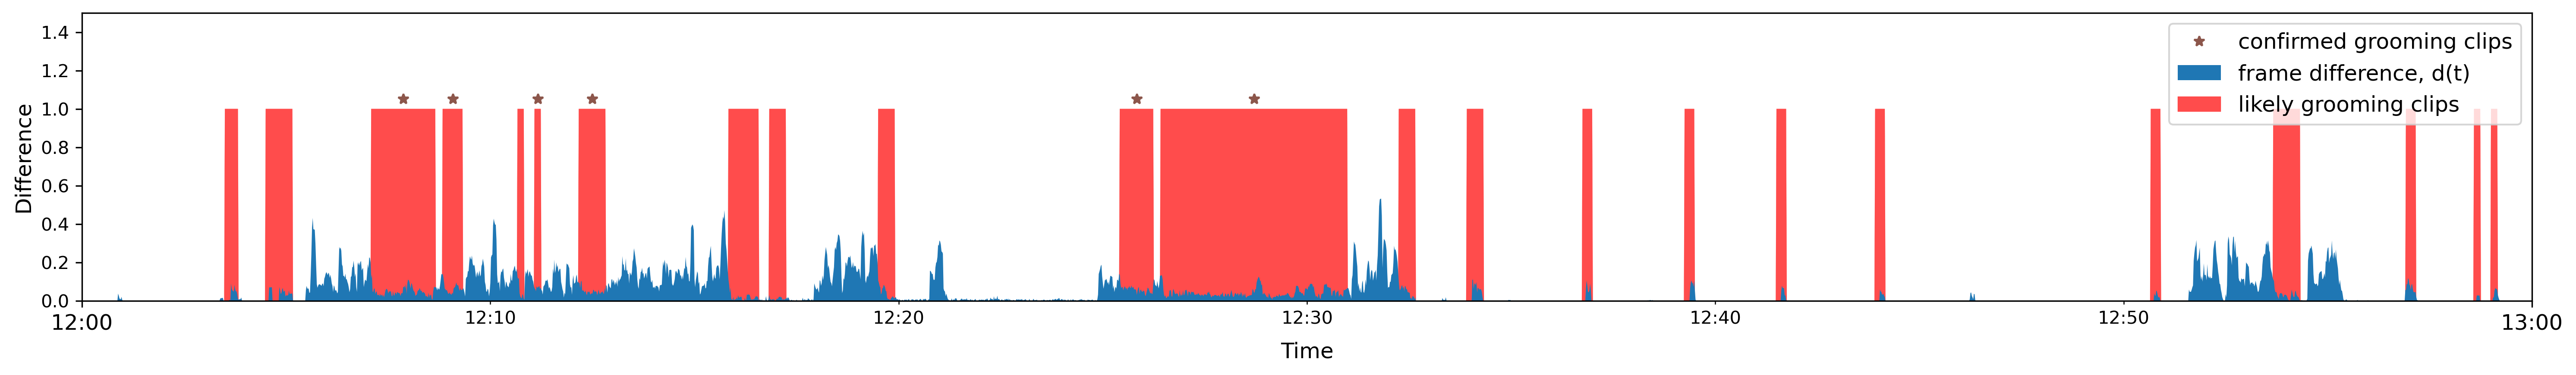

In [18]:
def plot_hours(df, ax, datemin, datemax, title, fname, ssgroom):
    ax.set_ylim(0, 1.5)

    # format the ticks
    mins = mdates.MinuteLocator(interval=10) 
    ax.xaxis.set_minor_locator( mins )
    ax.xaxis.set_minor_formatter(tm_fmt)
    ax.xaxis.set_major_locator(hours)
    ax.xaxis.set_major_formatter(tm_fmt)
    
    ax.format_xdata = tm_fmt
    ax.set_xlim(datemin, datemax)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Difference', fontsize=12)
#     ax.fill_between('time', 'pred', data=df,  lw=0.2)
    ax.fill_between('time', 'label', data=df, color='r',  lw=0.1, alpha=0.7 , label='likely grooming clips') # 
    ax.fill('time', 'nonzero_p5', data=df, label='frame difference, d(t)' )
    
    yy = [1.05]*len(ssgroom)
    ax.plot(ssgroom, yy, '*', color='tab:brown', label='confirmed grooming clips')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(12)    
        
    legend = ax.legend(fontsize=12)    
    plt.savefig(fname, dpi=300)

titleL = '{}_L'.format('217')
datemin = np.datetime64('1970-01-01 12:00') 
datemax = np.datetime64('1970-01-01 13:00') 
last_min = dfL.iloc[-1]['time'].minute

print('datemax ', datemax)

f, ax = plt.subplots(1, 1, figsize=(20, 3), dpi=300, sharex=True)
plt.subplots_adjust(hspace=0.30)
# dfL['nonzero_p5'] = dfL['nonzero_p5']*2    
fname = 'fig3b_frame_difference_profile_12-13.png'
plot_hours(dfL, ax, datemin, datemax, titleL, fname, df_groom['time'])

# img1 = cv.imread(fname)
# crop_img = img1[:, 400:-350]
# cv.imwrite(fname, crop_img)
print(fname)